In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
import sys

In [2]:
dir_current = os.path.abspath('')
dir_parent  = os.path.dirname(dir_current)
if not dir_parent in sys.path: sys.path.append(dir_parent)

## Loading Dataset

In [3]:
# Loading Data
(_, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# Normalizando
x_test = x_test/255.
# Adding Channel Lenght Dimension: Expanding from (28x28) to (28x28x1)
x_test = tf.expand_dims(x_test, -1)

## Creating Dataset Objects

In [4]:
Nclasses = 10
def to_categorical(x_, y_):
    return x_, tf.one_hot(y_, depth = Nclasses)

In [5]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(to_categorical)
test_dataset = test_dataset.batch(1)

## Loading Quantized model and Non Quantized model 

In [6]:
import gc
from models import Lenet_body, Weight_Quantization
from tensorflow.python.keras import backend as K 

# Original lenet
input_layer   = tf.keras.Input((28, 28, 1))
output_layer  = Lenet_body(input_layer, Quantization = False)
Lenet  = tf.keras.Model(inputs=input_layer, outputs=output_layer)
cwd = os.getcwd()
Wgt_dir = os.path.join(cwd,'TrainedWeights')
Wgt_dir = os.path.join(Wgt_dir,'Weights')
Lenet.load_weights(Wgt_dir)
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
metrics = ['accuracy']
Lenet.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Quantized Lenet
def Check_Accuracy_and_Loss_Lenet(test_dataset, Afrac_size, Aint_size, N_labels, Weights_file, 
                                Wfrac_size, Wint_size, FCWfrac_size, FCWint_size):
    #Create Quantized Model
    Qinput_layer  = tf.keras.Input((28,28,1))
    Qoutput_layer = Lenet_body(Qinput_layer, Quantization = True,
                               word_size = (1 + Afrac_size + Aint_size), frac_size = Afrac_size)
    QLenet = tf.keras.Model(inputs=Qinput_layer, outputs=Qoutput_layer)
    #Load Weights
    cwd = os.getcwd()
    Wgt_dir = os.path.join(cwd,'TrainedWeights')
    Wgt_dir = os.path.join(Wgt_dir,'Weights')
    QLenet.load_weights(Wgt_dir).expect_partial()
    #Quantize Weights
    Weight_Quantization(model = QLenet, Frac_Bits = Wfrac_size, Int_Bits = Wint_size,
                        Dense_Frac_Bits = FCWfrac_size, Dense_Int_Bits = FCWint_size)
    # Params
    loss = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    metrics = ['accuracy']
    # Compile Model
    QLenet.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    (loss,acc) = QLenet.evaluate(test_dataset)
    # Cleaning Memory
    del QLenet
    gc.collect()
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    return loss,acc

## Original model Accuracy

In [7]:
(NQloss,NQacc) = Lenet.evaluate(test_dataset)

10000/10000 [==============================] - 35s 4ms/step - loss: 0.3196 - accuracy: 0.8883


# Experiment 1: Looking for a starting point of precision

In [8]:
# Conditions: No saturation => 4 bits int activations, 1 bits int weights
E1_Frac_bits = [1,2,3,4]
E1_acc       = [None]*4
E1_loss      = [None]*4
for index in range(0,4):
    (E1_loss[index],E1_acc[index]) = Check_Accuracy_and_Loss_Lenet(test_dataset = test_dataset, 
                                                                     Weights_file = 'Weights',
                                                                     N_labels = 10,
                                                                     Afrac_size   = E1_Frac_bits[index], Aint_size   = 4,
                                                                     Wfrac_size   = E1_Frac_bits[index], Wint_size   = 1,
                                                                     FCWfrac_size = E1_Frac_bits[index], FCWint_size = 1)

10000/10000 [==============================] - 34s 3ms/step - loss: 0.5413 - accuracy: 0.8823


# Experiment 2: Seeking minimum number of bits for fractional part in Weights

In [11]:
# Conditions: No saturation => 4 bits int activations, 1 bits int weights
#             Enough Precision in Activations => 4 bits frac activations
E2_Frac_bits = [1,2,3,4]
E2_acc       = [None]*4
E2_loss      = [None]*4
for index in range(0,4):
    (E2_loss[index],E2_acc[index]) = Check_Accuracy_and_Loss_Lenet(test_dataset = test_dataset, 
                                                                     Weights_file = 'Weights',
                                                                     N_labels = 10,
                                                                     Afrac_size   =                   4, Aint_size   = 4,
                                                                     Wfrac_size   = E2_Frac_bits[index], Wint_size   = 1,
                                                                     FCWfrac_size = E2_Frac_bits[index], FCWint_size = 1)

10000/10000 [==============================] - 35s 3ms/step - loss: 0.5413 - accuracy: 0.8823


# Experiment 3: Seeking minimum number of bits for fractional part in Activations

In [12]:
# Conditions: No saturation => 4 bits int activations, 1 bits int weights
#             Enough Precision in Weights => 4 bits frac weights
E3_Frac_bits = [1,2,3,4]
E3_acc       = [None]*4
E3_loss      = [None]*4
for index in range(0,4):
    (E3_loss[index],E3_acc[index]) = Check_Accuracy_and_Loss_Lenet(test_dataset = test_dataset, 
                                                                     Weights_file = 'Weights',
                                                                     N_labels = 10,
                                                                     Afrac_size   = E3_Frac_bits[index], Aint_size   = 4,
                                                                     Wfrac_size   =                   4, Wint_size   = 1,
                                                                     FCWfrac_size =                   4, FCWint_size = 1)

10000/10000 [==============================] - 35s 4ms/step - loss: 0.5413 - accuracy: 0.8823


# Experiment 4: Searching for minimum number of bits in integer part of Weights

In [13]:
# Conditions: Enough Precision in Activation => 3 bits frac activations
#             Enough Precision in Weights    => 4 bits frac weights
#             No saturation in Activations   => 4 bits int activations
E4_Int_bits  = [0,1]
E4_acc       = [None]*2
E4_loss      = [None]*2
for index in range(0,2):
    (E4_loss[index],E4_acc[index]) = Check_Accuracy_and_Loss_Lenet(test_dataset = test_dataset, 
                                                                     Weights_file = 'Weights',
                                                                     N_labels = 10,
                                                                     Afrac_size   =   3, Aint_size   = 4,
                                                                     Wfrac_size   =   4, Wint_size   = E4_Int_bits[index],
                                                                     FCWfrac_size =   4, FCWint_size = E4_Int_bits[index])

10000/10000 [==============================] - 34s 3ms/step - loss: 0.6825 - accuracy: 0.8808


# Experiment 5: Searching for minimum number of bits in integer part of Activations

In [14]:
# Conditions: Enough Precision in Activation => 3 bits frac activations
#             Enough Precision in Weights    => 4 bits frac weights
#             Enough integer bits in Weights => 0 bits int weights
E5_Int_bits  = [1,2,3]
E5_acc       = [None]*3
E5_loss      = [None]*3
for index in range(0,3):
    (E5_loss[index],E5_acc[index]) = Check_Accuracy_and_Loss_Lenet(test_dataset = test_dataset, 
                                                                     Weights_file = 'Weights',
                                                                     N_labels = 10,
                                                                     Afrac_size   =   3, Aint_size   = E5_Int_bits[index],
                                                                     Wfrac_size   =   4, Wint_size   = 0,
                                                                     FCWfrac_size =   4, FCWint_size = 0)

10000/10000 [==============================] - 34s 3ms/step - loss: 0.6374 - accuracy: 0.8801


# Best Experimental Quantization

In [15]:
# Weights:        Precision = 4, Integer part = 0
# Activations:    Precision = 3, Integer part = 3
 
Check_Accuracy_and_Loss_Lenet(test_dataset = test_dataset, Weights_file = 'Weights', N_labels = 10,
                                Afrac_size = 3, Aint_size = 3, Wfrac_size = 4, Wint_size   = 0, 
                                FCWfrac_size = 4, FCWint_size = 0)

10000/10000 [==============================] - 35s 4ms/step - loss: 0.6374 - accuracy: 0.8801


(0.6373524806737901, 0.8801)

## Comparative Plot

In [17]:
import matplotlib.pyplot as plt

def Plot_Experiments(Nexp, figsize, Qbits, xlabel, E_acc, E_loss, NQacc, NQloss , save_fig=False):
    fig, axs = plt.subplots(1,2,figsize = figsize)
    fig.suptitle('Lenet Experiment '+ str(Nexp), fontsize=20)
    
    axs[0].set_xticks(Qbits)
    axs[0].set_ylim([0, 1])
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel('Accuracy',fontsize=14)
    axs[0].axhline(y=NQacc, color='r', linestyle='-')
    axs[0].plot(Qbits, E_acc, color = 'b', linestyle='-')
    axs[0].legend(('Original Model','Quantized Model'))
    
    
    axs[1].set_xticks(Qbits)
    axs[1].set_ylim([0, int(np.floor(np.max(E_loss)) + 1)])
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel('Loss',fontsize=14)
    axs[1].axhline(y=NQloss, color='r', linestyle='-')
    axs[1].plot(Qbits, E_loss, color = 'b', linestyle='-')
    axs[1].legend(('Original Model','Quantized Model'))
    
    if save_fig:
        fig.savefig('Figuras/Experimentos_Cuantizacion/Lenet 5 Quantization Experiment '+str(Nexp)+'.png')

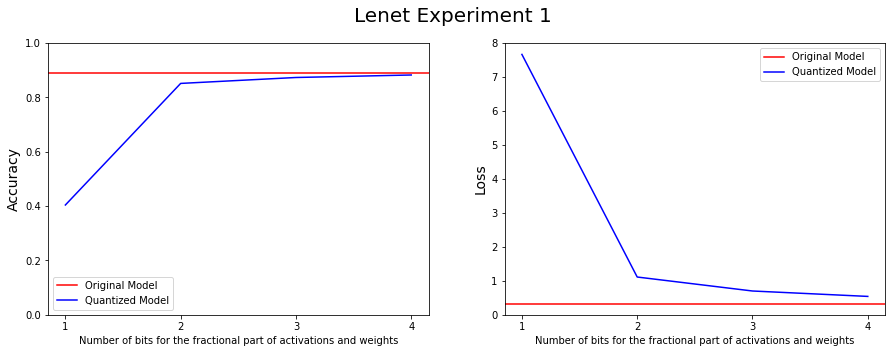

In [18]:
Plot_Experiments(Nexp = 1, figsize = (15,5), Qbits = E1_Frac_bits,
                 xlabel = 'Number of bits for the fractional part of activations and weights',
                 E_acc = E1_acc, E_loss = E1_loss, 
                 NQacc = NQacc , NQloss = NQloss ,
                 save_fig=True )

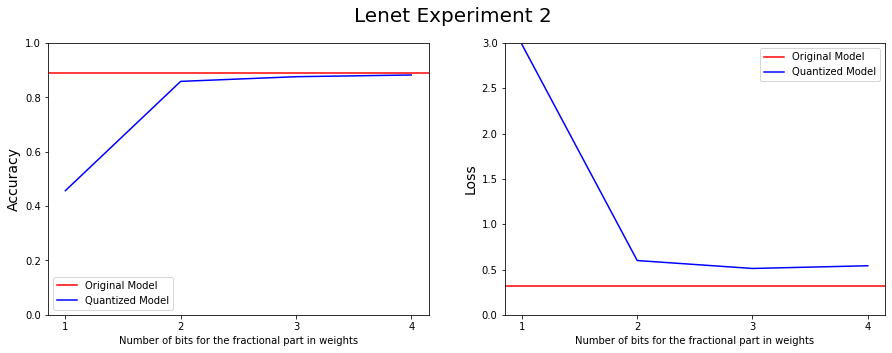

In [19]:
Plot_Experiments(Nexp = 2, figsize = (15,5), Qbits = E2_Frac_bits,
                 xlabel = 'Number of bits for the fractional part in weights',
                 E_acc = E2_acc, E_loss = E2_loss, 
                 NQacc = NQacc , NQloss = NQloss ,
                 save_fig=True)

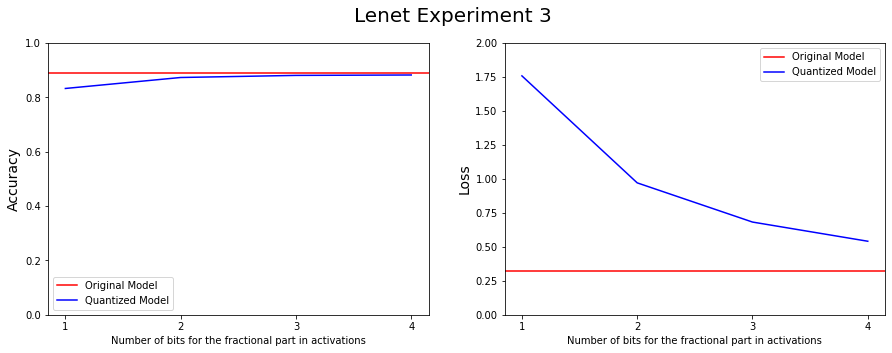

In [20]:
Plot_Experiments(Nexp = 3, figsize = (15,5), Qbits = E3_Frac_bits,
                 xlabel = 'Number of bits for the fractional part in activations',
                 E_acc = E3_acc, E_loss = E3_loss, 
                 NQacc = NQacc , NQloss = NQloss ,
                 save_fig=True)

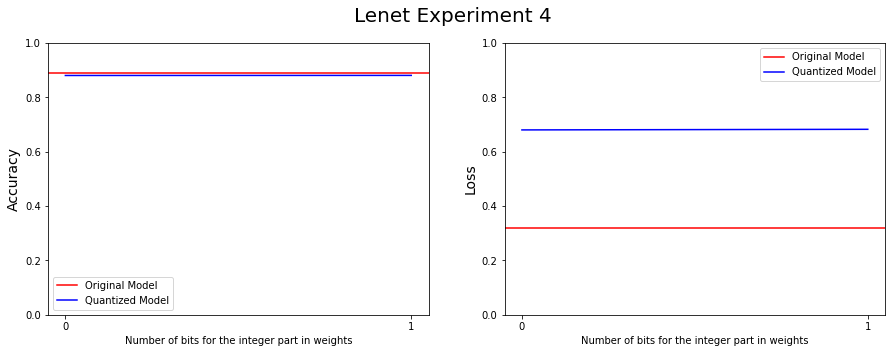

In [21]:
Plot_Experiments(Nexp = 4, figsize = (15,5), Qbits = E4_Int_bits,
                 xlabel = 'Number of bits for the integer part in weights',
                 E_acc = E4_acc, E_loss = E4_loss, 
                 NQacc = NQacc , NQloss = NQloss ,
                 save_fig=True)

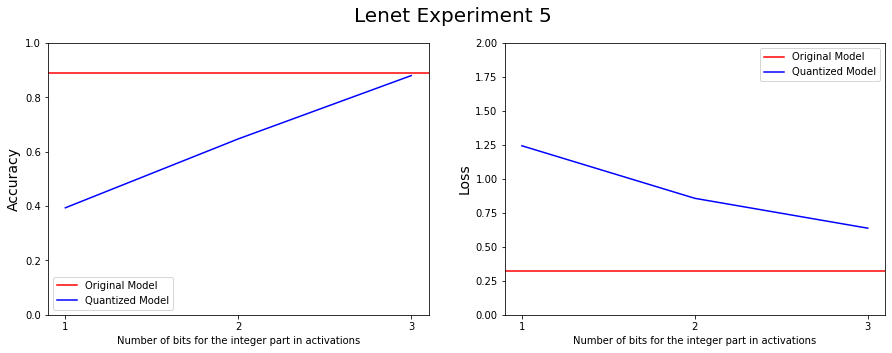

In [22]:
Plot_Experiments(Nexp = 5, figsize = (15,5), Qbits = E5_Int_bits,
                 xlabel = 'Number of bits for the integer part in activations',
                 E_acc = E5_acc, E_loss = E5_loss, 
                 NQacc = NQacc , NQloss = NQloss ,
                 save_fig=True)